# Stochastic Raytracer

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


%load_ext autoreload
%autoreload 2

### Load a scene 

We will us the utility functions to do so. Have a look at the predefined scenes.

In [2]:
from utils.scene import parse_scene, all_object_types
for t in all_object_types:
    exec("%s = t" % t.__name__)
    
%ls ./scenes

small01.yaml


These are the objects the scene contains we chose

In [3]:
objects = parse_scene('./scenes/small01.yaml')
print([key for key in objects])

['ball_1', 'ball_2', 'floor', 'wall', 'light_1', 'light_2', 'camera']


Now seperate the objects into different rendering classes

In [4]:
camera = objects['camera']
objects.pop('camera')

lights = {key: objects[key] for key in objects if 'light' in key}
for light in lights: objects.pop(light)

print('Solids: ', [key for key in objects])
print('Lights: ', [key for key in lights])

Solids:  ['ball_1', 'ball_2', 'floor', 'wall']
Lights:  ['light_1', 'light_2']


### Fresnel Shader

Using Fresnel's equations reflections and refractions can be modeled quite well using an iterative approach. Assuming that light sometimes passes through an object and others is reflected gives us a stochastic renderer. We want to know the expected pixel color that results from randomly either reflecting or reflecting light rays at any collision. 

![bouncing](./images/rendering_iterations.png)


A rendering iteration basically bounces light rays from an object to the next. The total number of iterations will be fixed and rather small. If caustics and other artifacts are desired photon mapping can be employed additionally but let us keep it simple for now. 


In [ ]:
def shader(rays, normals, alpha, n_mat1, n_mat2 ):
    s,d = rays
    N = s.shape[0]
    
    assert s.shape==(N,3) and d.shape==(N,) and normals.shape==(N,3) \
        and alpha.shape == n_mat1.shape == n_mat2.shape == (N,), \
        'Shapes of input parameters incorrect.'
    
    

### Stochastic Beam

Not only do we have a bit of randomness from reflections and refractions but also from approximating a light beam by a single light ray. We randomly perturb the light rays slightly to simulate different rays within the beam.


We will assume the beam consists of Gaussianly distributed rays. To be precise the angular deviation is Gaussianly distributed. Depicting the standard deviation of the distribution as in the image below the beam is shaped like a cone

![stochastic beam](./images/stochastic_beam.png)


To sample rays from this Gaussian distibution let us write an auxiliary function 

In [64]:
def sample_angular_dispersion(directions, n_samples=10, angular_std=None):
    assert len(directions.shape) == 2 and directions.shape[1] == 3, \
        'Directional vectors should have shape (N,3)'
    N = directions.shape[0]
    
    if angular_std is None: angular_std = np.deg2rad(5.0)
    angular_std = np.asarray(angular_std)
    if len(angular_std.shape)==0 or angular_std.shape==(1,): 
        angular_std = np.repeat(angular_std, N, axis=0)
        
    assert len(angular_std.shape) == 1 and angular_std.shape[0] == N, \
        'Angular standards should have same number of elements as directional vectors.'
    
    #sample rotation axis uniformly from sphere via rejection sampling
    attempts = 100
    for _ in range(attempts):
        rotation_axis = np.random.normal(size=(N,n_samples,3))
        if np.all( np.sum(rotation_axis**2, axis=-1) > 0 ): break
    if _ == attempts-1: print('All samples rejected! Run again.') # doesn't happen in practise!
    
    rotation_axis = rotation_axis / np.sqrt( np.sum(rotation_axis**2, axis=-1) + 1e-9 )[:,:,None]
        
    #sample angle from normal distribution 
    angles = np.random.normal(scale=angular_std[:,None], size=(N,n_samples))
    
    #rotate directional vector according to Rodrigues' rotation formula
    d_new = np.cos(angles)[:,:,None] * directions[:,None,:] 
    d_new = d_new + np.sin(angles)[:,:,None] * np.cross(rotation_axis, directions[:,None,:]) 
    d_new = d_new + (1-np.cos(angles))[:,:,None] * rotation_axis * \
        np.sum(rotation_axis * directions[:,None,:], axis=-1)[:,:,None] 
    
    return d_new

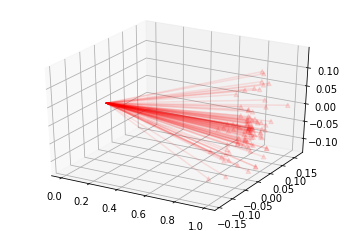

In [65]:
rays = np.array([[1,0,0]])
rays = sample_angular_dispersion(rays, 100, np.deg2rad(5.))
rays = rays[0,:,:]
                                
fig = plt.figure()
ax = plt.axes(projection='3d')

x,y,z = rays[:,0],rays[:,1],rays[:,2]
ax.scatter(x, y, z, c='r', marker='^', alpha=.1)

N = rays.shape[0]
for r in range(N):
    plt.plot([0,x[r]],[0,y[r]],[0,z[r]], color='r', alpha=.1)

plt.show()

Reimplement the rendering routines, this time with an additional axis for the samples. 

In [7]:
def construct_initial_rays(camera, n_samples=10):
    
    #read camera parameters
    W,H = camera.width, camera.height
    fov = np.deg2rad( camera.field_of_view )
    f = camera.focal_length
    
    #construct screen coordinates
    ii,jj = np.mgrid[:W,:H]
    s = f * np.array([
        np.sin(fov)     * (2*ii/(W-1) -1 ),
        np.sin(fov)*H/W * (2*jj/(H-1) -1 ),
        -np.ones((W,H)),
    ]).transpose((1,2,0))
    
    #sample from cone with pixel's field of view 
    polar_right_ray = np.sin(fov) * (2*(ii+1)/(W-1) -1 ) 
    polar_left_ray  = np.sin(fov) * (2*(ii-1)/(W-1) -1 )
    polar_right_ray = np.arctan(polar_right_ray)
    polar_left_ray  = np.arctan(polar_left_ray)
    
    angles = np.abs(polar_right_ray - polar_left_ray)
    d = s / np.sqrt( np.sum(s**2, axis=-1) )[:,:,None]
    d = sample_angular_dispersion( d[:,:,None,:], n_samples, angles[:,:,None] )
    
    #expand and squeeze shape to fit
    d = d[:,:,0,:,:]
    s = s[:,:,None,:]
    return s,d

Now calculate the intersections for all samples simultaneously.

In [8]:
def intersection_rays_sphere(rays, sphere, only_return_dist=False):
    s,d = rays
    center = sphere.center[None,:]
    
    #quadratic coefficients
    a = np.sum( d**2, axis=-1 )
    b = np.sum( d * (s - center), axis=-1)
    c = np.sum( (s - center)**2, axis=-1 ) - sphere.radius**2
    
    #intersection parameter
    intersection = b**2 > a*c + 1e-6
    residual = np.sqrt( np.maximum(0, b**2-a*c) + 1e-6 )
    dist = - np.ones(intersection.shape)
    dist_back  = np.where(intersection, (-b+residual)/a, -1)
    dist_front = np.where(intersection, (-b-residual)/a, -1)
    dist = np.where(intersection & (dist_back > 0), dist_back, dist)
    dist = np.where(intersection & (dist_front > 0), dist_front, dist)
    if only_return_dist: return dist
    
    #print('s', s.shape)
    #print('t', depth.shape)
    #print('n', normal.shape)
    
    #next rays
    intersection = depth > 0
    intersection = intersection[:,None]
    s_next = np.where(intersection, s + dist[:,None] * d, s)
    normal = np.where(intersection, s_next - center[None,:], 0)
    normal = np.where(intersection, normal / np.sum(normal**2, axis=-1)[:,None], 1 )
    
    d_refracted = 
    d_reflected = 2 * np.sum(normal * d, axis=-1)[:,None] * normal - d
    
    rays_next = (s_next, d_next)
    
    return dist, rays_next, normal

In [9]:
def intersection_rays_plane(rays, plane, only_return_dist=False):
    s,d = rays
    support = plane.support[None,None,None,:]
    normal  = plane.normal[None,None,None,:]
    
    #intersection parameter
    a = np.sum( normal * d, axis=-1 ) 
    b = np.sum( normal * (s-support), axis=-1 )
    
    intersection = np.abs(a) > 1e-3
    dist = np.where(intersection, -b/a, -1)
    dist = np.where(dist>0, dist, -1)
    if only_return_dist: return dist

    #next rays
    #intersection = depth > 0
    #s_next = np.where(intersection[:,:,:,None], s + depth[:,:,:,None] * d, s)
    #d_next = 2 * np.sum(normal * d, axis=-1)[:,:,:,None] * normal - d
    #rays_next = (s_next, d_next)
    
    #return rays_next, depth, normal

Let us test the stochastic intersection distance calculations. The images that have been generated show  

In [10]:
rays = construct_initial_rays(camera, n_samples=4)
depth_buffer = - np.ones((camera.width, camera.height))


#intersect rays with all objects
s,d = rays 
for name in objects:
    obj = objects[name]
    if type(obj)==Sphere:
        dist = intersection_rays_sphere(rays, obj, only_return_dist=True)
    elif type(obj)==Plane:
        dist = intersection_rays_plane(rays, obj, only_return_dist=True)
    
    #calculate intersection attributes 
    mask_samples = dist > 0
    mask_pixels  = np.any(mask_samples, axis=-1)
    
    weights = np.where(mask_pixels, np.sum(mask_samples, axis=-1), 1)
    mean_dist = np.sum(np.maximum(0,dist), axis=-1)
    mean_dist = mean_dist / weights
    
    #update depth buffer
    mask = mean_dist>0
    mask = mask & ((depth_buffer<0) | (mean_dist<depth_buffer) )
    depth_buffer = np.where(mask, mean_dist, depth_buffer)

    #display current object
    img = mean_dist
    plt.figure(figsize = (10,10)) 
    plt.imshow(img[:,::-1].transpose(), cmap='gray', vmin=0., vmax=10.)
    plt.title('Distance of object %s' % name)
    plt.show()
        
#display depth buffer        
img = depth_buffer
plt.figure(figsize = (10,10)) 
plt.imshow(img[:,::-1].transpose(), cmap='gray', vmin=0., vmax=10.)
plt.title('Depth Buffer')
plt.show()


AssertionError: Directional vectors should have shape (N,3)